# Example: Human segmentation with attention U-net and transfer learning from ImageNet-trained VGG16 model

In [18]:
pip install keras-unet-collection

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
from glob import glob

In [20]:
from tensorflow import keras

This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [21]:
from keras_unet_collection import models, utils

In [22]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/kaggle/input/ihc-wunu-v17/'
filepath_label = '/kaggle/input/ihc-wunu-v17/'

## The COCO-stuff dataset

The [COCO-stuff](https://github.com/nightrome/cocostuff) is a segmentation benchmark dataset based on the full samples of [COCO 2017](https://cocodataset.org/#download) --- a large-scale object detection, segmentation, and captioning dataset, with pixel-level annotations.

COCO-stuff consists of RGB image samples with both indoor and outdoor backgrounds. The segmentation focus of this example, human/person, is one of the COCO-stuff "things" class.

The code cell below downloads the COCO 2017 samples (`train2017.zip` and `val2017.zip`) and COCO-stuff annotations (`stuffthingmaps_trainval2017.zip`). 

**Note**:
* The total size of COCO 2017 is 20 GB. For saving its zipped and unzipped versions, a storage space of 40 GB is required.

* `wget` is called through `subprocess.Popen`. Access download links mannually if the call failed.

In [23]:
# downloading and executing data files
if first_time_running:
    
    import zipfile
    import urllib.request
    import subprocess
    
    local_names = ['train2017.zip', 'val2017.zip', 'stuffthingmaps_trainval2017.zip']
    
    urls = ['http://images.cocodataset.org/zips/train2017.zip', 
            'http://images.cocodataset.org/zips/val2017.zip', 
            'http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip']
    
    for i, local_name in enumerate(local_names):
        
        print("Accessing <{}>".format(local_name))
        filename = filepath + local_name
        
        # calvin group labels
        if i == 2:
            subprocess.Popen(['wget', '-O', filename, urls[i]]) # <--- wget
            with zipfile.ZipFile(filename, 'r') as zip_io:
                zip_io.extractall(filepath_label) 
        # coco train/val images
        else:
            urllib.request.urlretrieve(urls[i], filename);    
            with zipfile.ZipFile(filename, 'r') as zip_io:
                zip_io.extractall(filepath)

In [24]:
# file path after data extraction
path_trainval_img = filepath + '/train/images/'
path_trainval_mask = filepath_label + 'train/masks/'
path_test_img = filepath + 'val/images/'
path_test_mask = filepath_label + 'val/masks/'

### Subsetting human samples

For obtaining a better focus of the segmentation target, human samples are subsetted from COCO.

The selection criteria is that after resizing to 128-by-128, human samples should have more than 33% of its 64-by-64 central pixels belong to the human/person category.

As a binary segmentation problem, non-human COCO-stuff labels are grouped and labelled as "background". Accessory categories (e.g., ties) are also grouped into the background.

**Note**: sample subsetting code cells are time-consuming.

In [25]:
def split_human_samples(label_filenames, human_id=0, human_rate=1/3):
    '''
    Subsetting samples that contain "person/human" category from the COCO dataset
    ----------
    human_id = 0 : COCO stuffthingmaps label human as int 0
    human_rate = 1/3: at least 33% of the pixels should belong to human.
    ----------
    '''
    thres = int(64*64*human_rate) # pixel number thres after resizing
    L = len(label_filenames)
    flag = [] # return a list of booleans
    for i in range(L):
        sample_ = utils.image_to_array([label_filenames[i]], size=256, channel=1)
        if np.sum(sample_[0, 32:-32, 32:-32, 0]==human_id) > thres:
            flag.append(True)
        else:
            flag.append(False)
        
    return flag

In [26]:
trainval_input_names = np.array(sorted(glob(path_trainval_img+'*.png')))
trainval_label_names = np.array(sorted(glob(path_trainval_mask+'*_mask.png')))
#flag_human = split_human_samples(trainval_label_names, human_id=0)
#trainval_input_names = trainval_input_names[flag_human]
#trainval_label_names = trainval_label_names[flag_human]

In [27]:
test_input_names = np.array(sorted(glob(path_test_img+'*.png')))
test_label_names = np.array(sorted(glob(path_test_mask+'*_mask.png')))
#flag_human_test = split_human_samples(test_label_names, human_id=0)
#test_input_names = test_input_names[flag_human_test]
#test_label_names = test_label_names[flag_human_test]

### Training-validation data split

The COCO validation samples are treated as testing sets.

The validation data of this example is split form the COCO training samples. 

In [28]:
L = len(trainval_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.7*L); L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

train_input_names = trainval_input_names[ind_train]
train_label_names = trainval_label_names[ind_train]
valid_input_names = trainval_input_names[ind_valid]
valid_label_names = trainval_label_names[ind_valid]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, len(test_label_names)))

Training:validation:testing = 140:60:40


### Exploratory data analysis

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [30]:
i_max = 10 # explore 10 images
input_example = utils.image_to_array(train_input_names[:i_max], size=256, channel=3)
label_example = utils.image_to_array(train_label_names[:i_max], size=256, channel=1)

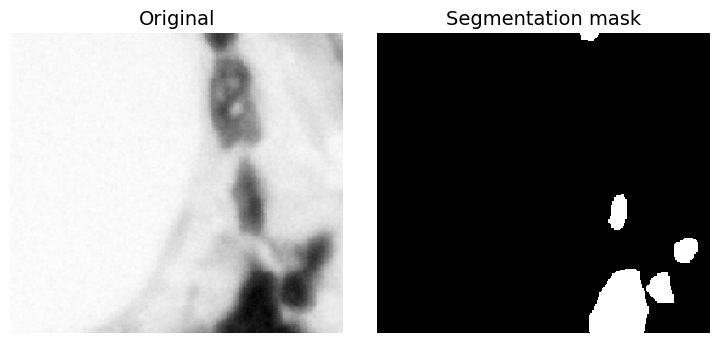

In [31]:
i_example = 5

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
    
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0]>0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Segmentation mask", fontsize=14);

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [32]:
#model = models.att_unet_2d((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
#                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
#                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
#                           batch_norm=True, pool=False, unpool=False, 
#                           backbone='VGG16', weights='imagenet', 
#                           freeze_backbone=True, freeze_batch_norm=True, 
#                           name='attunet')

The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [33]:
#model = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=2,
#                      stack_num_down=2, stack_num_up=1,
#                      activation='GELU', output_activation='Softmax', 
#                      batch_norm=True, pool='max', unpool='nearest', name='unet')

In [34]:
model = models.r2_unet_2d((256, 256, 3), [32, 64, 128, 256, 512, 1024], n_labels=2,
                          stack_num_down=2, stack_num_up=1, recur_num=3,
                          activation='GELU', output_activation='Softmax', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

In [35]:
from tensorflow import math
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K


def gelu_(X):

    return 0.5*X*(1.0 + math.tanh(0.7978845608028654*(X + 0.044715*math.pow(X, 3))))

def snake_(X, beta):

    return X + (1/beta)*math.square(math.sin(beta*X))


class GELU(Layer):
    '''
    Gaussian Error Linear Unit (GELU), an alternative of ReLU
    
    Y = GELU()(X)
    
    ----------
    Hendrycks, D. and Gimpel, K., 2016. Gaussian error linear units (gelus). arXiv preprint arXiv:1606.08415.
    
    Usage: use it as a tf.keras.Layer
    
    
    '''
    def __init__(self, trainable=False, **kwargs):
        super(GELU, self).__init__(**kwargs)
        self.supports_masking = True
        self.trainable = trainable

    def build(self, input_shape):
        super(GELU, self).build(input_shape)

    def call(self, inputs, mask=None):
        return gelu_(inputs)

    def get_config(self):
        config = {'trainable': self.trainable}
        base_config = super(GELU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    def compute_output_shape(self, input_shape):
        return input_shape

    
class Snake(Layer):
    '''
    Snake activation function $X + (1/b)*sin^2(b*X)$. Proposed to learn periodic targets.
    
    Y = Snake(beta=0.5, trainable=False)(X)
    
    ----------
    Ziyin, L., Hartwig, T. and Ueda, M., 2020. Neural networks fail to learn periodic functions 
    and how to fix it. arXiv preprint arXiv:2006.08195.
    
    '''
    def __init__(self, beta=0.5, trainable=False, **kwargs):
        super(Snake, self).__init__(**kwargs)
        self.supports_masking = True
        self.beta = beta
        self.trainable = trainable

    def build(self, input_shape):
        self.beta_factor = K.variable(self.beta, dtype=K.floatx(), name='beta_factor')
        if self.trainable:
            self._trainable_weights.append(self.beta_factor)

        super(Snake, self).build(input_shape)

    def call(self, inputs, mask=None):
        return snake_(inputs, self.beta_factor)

    def get_config(self):
        config = {'beta': self.get_weights()[0] if self.trainable else self.beta, 'trainable': self.trainable}
        base_config = super(Snake, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
    

In [36]:
from __future__ import absolute_import

from keras_unet_collection.activations import GELU, Snake
from tensorflow import expand_dims
from tensorflow.compat.v1 import image
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, concatenate, multiply, add
from tensorflow.keras.layers import ReLU, LeakyReLU, PReLU, ELU, Softmax

def decode_layer(X, channel, pool_size, unpool, kernel_size=3, 
                 activation='ReLU', batch_norm=False, name='decode'):
    '''
    An overall decode layer, based on either upsampling or trans conv.
    
    decode_layer(X, channel, pool_size, unpool, kernel_size=3,
                 activation='ReLU', batch_norm=False, name='decode')
    
    Input
    ----------
        X: input tensor.
        pool_size: the decoding factor.
        channel: (for trans conv only) number of convolution filters.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.           
        kernel_size: size of convolution kernels. 
                     If kernel_size='auto', then it equals to the `pool_size`.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
    
    * The defaut: `kernel_size=3`, is suitable for `pool_size=2`.
    
    '''
    # parsers
    if unpool is False:
        # trans conv configurations
        bias_flag = not batch_norm
    
    elif unpool == 'nearest':
        # upsample2d configurations
        unpool = True
        interp = 'nearest'
    
    elif (unpool is True) or (unpool == 'bilinear'):
        # upsample2d configurations
        unpool = True
        interp = 'bilinear'
    
    else:
        raise ValueError('Invalid unpool keyword')
        
    if unpool:
        X = UpSampling2D(size=(pool_size, pool_size), interpolation=interp, name='{}_unpool'.format(name))(X)
    else:
        if kernel_size == 'auto':
            kernel_size = pool_size
            
        X = Conv2DTranspose(channel, kernel_size, strides=(pool_size, pool_size), 
                            padding='same', name='{}_trans_conv'.format(name))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_bn'.format(name))(X)
            
        # activation
        if activation is not None:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
        
    return X

def encode_layer(X, channel, pool_size, pool, kernel_size='auto', 
                 activation='ReLU', batch_norm=False, name='encode'):
    '''
    An overall encode layer, based on one of the:
    (1) max-pooling, (2) average-pooling, (3) strided conv2d.
    
    encode_layer(X, channel, pool_size, pool, kernel_size='auto', 
                 activation='ReLU', batch_norm=False, name='encode')
    
    Input
    ----------
        X: input tensor.
        pool_size: the encoding factor.
        channel: (for strided conv only) number of convolution filters.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        kernel_size: size of convolution kernels. 
                     If kernel_size='auto', then it equals to the `pool_size`.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    # parsers
    if (pool in [False, True, 'max', 'ave']) is not True:
        raise ValueError('Invalid pool keyword')
        
    # maxpooling2d as default
    if pool is True:
        pool = 'max'
        
    elif pool is False:
        # stride conv configurations
        bias_flag = not batch_norm
    
    if pool == 'max':
        X = MaxPooling2D(pool_size=(pool_size, pool_size), name='{}_maxpool'.format(name))(X)
        
    elif pool == 'ave':
        X = AveragePooling2D(pool_size=(pool_size, pool_size), name='{}_avepool'.format(name))(X)
        
    else:
        if kernel_size == 'auto':
            kernel_size = pool_size
        
        # linear convolution with strides
        X = Conv2D(channel, kernel_size, strides=(pool_size, pool_size), 
                   padding='valid', use_bias=bias_flag, name='{}_stride_conv'.format(name))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_bn'.format(name))(X)
            
        # activation
        if activation is not None:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
            
    return X

def attention_gate(X, g, channel,  
                   activation='ReLU', 
                   attention='add', name='att'):
    '''
    Self-attention gate modified from Oktay et al. 2018.
    
    attention_gate(X, g, channel,  activation='ReLU', attention='add', name='att')
    
    Input
    ----------
        X: input tensor, i.e., key and value.
        g: gated tensor, i.e., query.
        channel: number of intermediate channel.
                 Oktay et al. (2018) did not specify (denoted as F_int).
                 intermediate channel is expected to be smaller than the input channel.
        activation: a nonlinear attnetion activation.
                    The `sigma_1` in Oktay et al. 2018. Default is 'ReLU'.
        attention: 'add' for additive attention; 'multiply' for multiplicative attention.
                   Oktay et al. 2018 applied additive attention.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X_att: output tensor.
    
    '''
    activation_func = eval(activation)
    attention_func = eval(attention)
    
    # mapping the input tensor to the intermediate channel
    theta_att = Conv2D(channel, 1, use_bias=True, name='{}_theta_x'.format(name))(X)
    
    # mapping the gate tensor
    phi_g = Conv2D(channel, 1, use_bias=True, name='{}_phi_g'.format(name))(g)
    
    # ----- attention learning ----- #
    query = attention_func([theta_att, phi_g], name='{}_add'.format(name))
    
    # nonlinear activation
    f = activation_func(name='{}_activation'.format(name))(query)
    
    # linear transformation
    psi_f = Conv2D(1, 1, use_bias=True, name='{}_psi_f'.format(name))(f)
    # ------------------------------ #
    
    # sigmoid activation as attention coefficients
    coef_att = Activation('sigmoid', name='{}_sigmoid'.format(name))(psi_f)
    
    # multiplicative attention masking
    X_att = multiply([X, coef_att], name='{}_masking'.format(name))
    
    return X_att

def CONV_stack(X, channel, kernel_size=3, stack_num=2, 
               dilation_rate=1, activation='ReLU', 
               batch_norm=False, name='conv_stack'):
    '''
    Stacked convolutional layers:
    (Convolutional layer --> batch normalization --> Activation)*stack_num
    
    CONV_stack(X, channel, kernel_size=3, stack_num=2, dilation_rate=1, activation='ReLU', 
               batch_norm=False, name='conv_stack')
    
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of stacked Conv2D-BN-Activation layers.
        dilation_rate: optional dilated convolution kernel.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor
        
    '''
    
    bias_flag = not batch_norm
    
    # stacking Convolutional layers
    for i in range(stack_num):
        
        activation_func = eval(activation)
        
        # linear convolution
        X = Conv2D(channel, kernel_size, padding='same', use_bias=bias_flag, 
                   dilation_rate=dilation_rate, name='{}_{}'.format(name, i))(X)
        
        # batch normalization
        if batch_norm:
            X = BatchNormalization(axis=3, name='{}_{}_bn'.format(name, i))(X)
        
        # activation
        activation_func = eval(activation)
        X = activation_func(name='{}_{}_activation'.format(name, i))(X)
        
    return X

def Res_CONV_stack(X, X_skip, channel, res_num, activation='ReLU', batch_norm=False, name='res_conv'):
    '''
    Stacked convolutional layers with residual path.
     
    Res_CONV_stack(X, X_skip, channel, res_num, activation='ReLU', batch_norm=False, name='res_conv')
     
    Input
    ----------
        X: input tensor.
        X_skip: the tensor that does go into the residual path 
                can be a copy of X (e.g., the identity block of ResNet).
        channel: number of convolution filters.
        res_num: number of convolutional layers within the residual path.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''  
    X = CONV_stack(X, channel, kernel_size=3, stack_num=res_num, dilation_rate=1, 
                   activation=activation, batch_norm=batch_norm, name=name)

    X = add([X_skip, X], name='{}_add'.format(name))
    
    activation_func = eval(activation)
    X = activation_func(name='{}_add_activation'.format(name))(X)
    
    return X

def Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, dilation_rate=1, activation='ReLU', batch_norm=False, name='sep_conv'):
    '''
    Depthwise separable convolution with (optional) dilated convolution kernel and batch normalization.
    
    Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, dilation_rate=1, activation='ReLU', batch_norm=False, name='sep_conv')
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of stacked depthwise-pointwise layers.
        dilation_rate: optional dilated convolution kernel.
        activation: one of the `tensorflow.keras.layers` interface, e.g., 'ReLU'.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
    
    '''
    
    activation_func = eval(activation)
    bias_flag = not batch_norm
    
    for i in range(stack_num):
        X = DepthwiseConv2D(kernel_size, dilation_rate=dilation_rate, padding='same', 
                            use_bias=bias_flag, name='{}_{}_depthwise'.format(name, i))(X)
        
        if batch_norm:
            X = BatchNormalization(name='{}_{}_depthwise_BN'.format(name, i))(X)

        X = activation_func(name='{}_{}_depthwise_activation'.format(name, i))(X)

        X = Conv2D(channel, (1, 1), padding='same', use_bias=bias_flag, name='{}_{}_pointwise'.format(name, i))(X)
        
        if batch_norm:
            X = BatchNormalization(name='{}_{}_pointwise_BN'.format(name, i))(X)

        X = activation_func(name='{}_{}_pointwise_activation'.format(name, i))(X)
    
    return X

def ASPP_conv(X, channel, activation='ReLU', batch_norm=True, name='aspp'):
    '''
    Atrous Spatial Pyramid Pooling (ASPP).
    
    ASPP_conv(X, channel, activation='ReLU', batch_norm=True, name='aspp')
    
    ----------
    Wang, Y., Liang, B., Ding, M. and Li, J., 2019. Dense semantic labeling 
    with atrous spatial pyramid pooling and decoder for high-resolution remote 
    sensing imagery. Remote Sensing, 11(1), p.20.
    
    Input
    ----------
        X: input tensor.
        channel: number of convolution filters.
        activation: one of the `tensorflow.keras.layers` interface, e.g., ReLU.
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    * dilation rates are fixed to `[6, 9, 12]`.
    '''
    
    activation_func = eval(activation)
    bias_flag = not batch_norm

    shape_before = X.get_shape().as_list()
    b4 = GlobalAveragePooling2D(name='{}_avepool_b4'.format(name))(X)
    
    b4 = expand_dims(expand_dims(b4, 1), 1, name='{}_expdim_b4'.format(name))
    
    b4 = Conv2D(channel, 1, padding='same', use_bias=bias_flag, name='{}_conv_b4'.format(name))(b4)
    
    if batch_norm:
        b4 = BatchNormalization(name='{}_conv_b4_BN'.format(name))(b4)
        
    b4 = activation_func(name='{}_conv_b4_activation'.format(name))(b4)
    
    # <----- tensorflow v1 resize.
    b4 = Lambda(lambda X: image.resize(X, shape_before[1:3], method='bilinear', align_corners=True), 
                name='{}_resize_b4'.format(name))(b4)
    
    b0 = Conv2D(channel, (1, 1), padding='same', use_bias=bias_flag, name='{}_conv_b0'.format(name))(X)

    if batch_norm:
        b0 = BatchNormalization(name='{}_conv_b0_BN'.format(name))(b0)
        
    b0 = activation_func(name='{}_conv_b0_activation'.format(name))(b0)
    
    # dilation rates are fixed to `[6, 9, 12]`.
    b_r6 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=6, batch_norm=True, name='{}_sepconv_r6'.format(name))
    b_r9 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=9, batch_norm=True, name='{}_sepconv_r9'.format(name))
    b_r12 = Sep_CONV_stack(X, channel, kernel_size=3, stack_num=1, activation='ReLU', 
                        dilation_rate=12, batch_norm=True, name='{}_sepconv_r12'.format(name))
    
    return concatenate([b4, b0, b_r6, b_r9, b_r12])

def CONV_output(X, n_labels, kernel_size=1, activation='Softmax', name='conv_output'):
    '''
    Convolutional layer with output activation.
    
    CONV_output(X, n_labels, kernel_size=1, activation='Softmax', name='conv_output')
    
    Input
    ----------
        X: input tensor.
        n_labels: number of classification label(s).
        kernel_size: size of 2-d convolution kernels. Default is 1-by-1.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                    Default option is 'Softmax'.
                    if None is received, then linear activation is applied.
        name: prefix of the created keras layers.
        
    Output
    ----------
        X: output tensor.
        
    '''
    
    X = Conv2D(n_labels, kernel_size, padding='same', use_bias=True, name=name)(X)
    
    if activation:
        
        if activation == 'Sigmoid':
            X = Activation('sigmoid', name='{}_activation'.format(name))(X)
            
        else:
            activation_func = eval(activation)
            X = activation_func(name='{}_activation'.format(name))(X)
            
    return X

In [37]:
from __future__ import absolute_import

from tensorflow.keras.applications import *
from tensorflow.keras.models import Model

from keras_unet_collection.utils import freeze_model

import warnings
print("work......")
layer_cadidates = {
    'VGG16': ('block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3'),
    'VGG19': ('block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4'),
    'ResNet50': ('conv1_conv', 'conv2_block3_1_relu', 'conv3_block4_1_relu', 'conv4_block3_1_relu','conv5_block6_1_relu', 'post_relu'),
    'ResNet101': ('conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block23_out', 'conv5_block3_out'),
    'ResNet152': ('conv1_relu', 'conv2_block3_out', 'conv3_block8_out', 'conv4_block36_out', 'conv5_block3_out'),
    'ResNet50V2': ('conv1_conv', 'conv2_block3_1_relu', 'conv3_block4_1_relu', 'conv4_block6_1_relu', 'post_relu'),
    'ResNet101V2': ('conv1_conv', 'conv2_block3_1_relu', 'conv3_block4_1_relu', 'conv4_block23_1_relu', 'post_relu'),
    'ResNet152V2': ('conv1_conv', 'conv2_block3_1_relu', 'conv3_block8_1_relu', 'conv4_block36_1_relu', 'post_relu'),
    'DenseNet121': ('conv1/relu', 'pool2_conv', 'pool3_conv', 'pool4_conv', 'relu'),
    'DenseNet169': ('conv1/relu', 'pool2_conv', 'pool3_conv', 'pool4_conv', 'relu'),
    'DenseNet201': ('conv1/relu', 'pool2_conv', 'pool3_conv', 'pool4_conv', 'relu'),
    'EfficientNetB0': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB1': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB2': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB3': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB4': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB5': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB6': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),
    'EfficientNetB7': ('block2a_expand_activation', 'block3a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_activation'),}

def bach_norm_checker(backbone_name, batch_norm):
    '''batch norm checker'''
    if 'VGG' in backbone_name:
        batch_norm_backbone = False
    else:
        batch_norm_backbone = True
        
    if batch_norm_backbone != batch_norm:       
        if batch_norm_backbone:    
            param_mismatch = "\n\nBackbone {} uses batch norm, but other layers received batch_norm={}".format(backbone_name, batch_norm)
        else:
            param_mismatch = "\n\nBackbone {} does not use batch norm, but other layers received batch_norm={}".format(backbone_name, batch_norm)
            
        warnings.warn(param_mismatch);
        
def backbone_zoo(backbone_name, weights, input_tensor, depth, freeze_backbone, freeze_batch_norm):
    '''
    Configuring a user specified encoder model based on the `tensorflow.keras.applications`
    
    Input
    ----------
        backbone_name: the bakcbone model name. Expected as one of the `tensorflow.keras.applications` class.
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0,7]
                       
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        input_tensor: the input tensor 
        depth: number of encoded feature maps. 
               If four dwonsampling levels are needed, then depth=4.
        
        freeze_backbone: True for a frozen backbone
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        model: a keras backbone model.
        
    '''
    print("layer_cadidateslayer_cadidateslayer_cadidateslayer_cadidateslayer_cadidateslayer_cadidates")
    cadidate = layer_cadidates[backbone_name]
    
    # ----- #
    # depth checking
    depth_max = len(cadidate)
    if depth > depth_max:
        depth = depth_max
    # ----- #
    
    backbone_func = eval(backbone_name)
    backbone_ = backbone_func(include_top=False, weights=weights, input_tensor=input_tensor, pooling=None,)
    
    X_skip = []
    
    for i in range(depth):
        X_skip.append(backbone_.get_layer(cadidate[i]).output)
        
    model = Model(inputs=[input_tensor,], outputs=X_skip, name='{}_backbone'.format(backbone_name))
    
    if freeze_backbone:
        model = freeze_model(model, freeze_batch_norm=freeze_batch_norm)
    
    return model

work......


In [38]:
from __future__ import absolute_import

from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._model_unet_2d import UNET_left, UNET_right
#from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model


def UNET_att_right(X, X_left, channel, att_channel, kernel_size=3, stack_num=2,
                   activation='ReLU', atten_activation='ReLU', attention='add',
                   unpool=True, batch_norm=False, name='right0'):
    '''
    the decoder block of Attention U-net.
    
    UNET_att_right(X, X_left, channel, att_channel, kernel_size=3, stack_num=2,
                   activation='ReLU', atten_activation='ReLU', attention='add',
                   unpool=True, batch_norm=False, name='right0')
    
    Input
    ----------
        X: input tensor
        X_left: the output of corresponded downsampling output tensor (the input tensor is upsampling input)
        channel: number of convolution filters
        att_channel: number of intermediate channel.        
        kernel_size: size of 2-d convolution kernels.
        stack_num: number of convolutional layers.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        atten_activation: a nonlinear attnetion activation.
                    The `sigma_1` in Oktay et al. 2018. Default is 'ReLU'.
        attention: 'add' for additive attention. 'multiply' for multiplicative attention.
                   Oktay et al. 2018 applied additive attention.
        unpool: True or "bilinear" for Upsampling2D with bilinear interpolation.
                "nearest" for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.  
        batch_norm: True for batch normalization, False otherwise.
        name: prefix of the created keras layers.
    Output
    ----------
        X: output tensor.
    
    '''
    
    pool_size = 2
    
    X = decode_layer(X, channel, pool_size, unpool, 
                     activation=activation, batch_norm=batch_norm, name='{}_decode'.format(name))
    
    X_left = attention_gate(X=X_left, g=X, channel=att_channel, activation=atten_activation, 
                            attention=attention, name='{}_att'.format(name))
    
    # Tensor concatenation
    H = concatenate([X, X_left], axis=-1, name='{}_concat'.format(name))
    
    # stacked linear convolutional layers after concatenation
    H = CONV_stack(H, channel, kernel_size, stack_num=stack_num, activation=activation, 
                   batch_norm=batch_norm, name='{}_conv_after_concat'.format(name))
    
    return H

def att_unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2,
                     activation='ReLU', atten_activation='ReLU', attention='add', batch_norm=False, pool=True, unpool=True, 
                     backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet'):
    '''
    The base of Attention U-net with an optional ImageNet backbone
    
    att_unet_2d_base(input_tensor, filter_num, stack_num_down=2, stack_num_up=2,
                     activation='ReLU', atten_activation='ReLU', attention='add', batch_norm=False, pool=True, unpool=True, 
                     backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-net: Learning where to look for the pancreas. arXiv preprint arXiv:1804.03999.
    
    Input
    ----------
        input_tensor: the input tensor of the base, e.g., `keras.layers.Inpyt((None, None, 3))`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.      
        atten_activation: a nonlinear atteNtion activation.
                    The `sigma_1` in Oktay et al. 2018. Default is 'ReLU'.
        attention: 'add' for additive attention. 'multiply' for multiplicative attention.
                   Oktay et al. 2018 applied additive attention.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.                  
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        X: the output tensor of the base.
    
    '''
    activation_func = eval(activation)

    depth_ = len(filter_num)
    X_skip = []

    # no backbone cases
    if backbone is None:
        X = input_tensor
        # downsampling blocks
        X = CONV_stack(X, filter_num[0], stack_num=stack_num_down, activation=activation, 
                       batch_norm=batch_norm, name='{}_down0'.format(name))
        X_skip.append(X)

        for i, f in enumerate(filter_num[1:]):
            X = UNET_left(X, f, stack_num=stack_num_down, activation=activation, pool=pool, 
                          batch_norm=batch_norm, name='{}_down{}'.format(name, i+1))        
            X_skip.append(X)

    else:
        # handling VGG16 and VGG19 separately
        if 'VGG' in backbone:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip)

        # for other backbones
        else:
            backbone_ = backbone_zoo(backbone, weights, input_tensor, depth_-1, freeze_backbone, freeze_batch_norm)
            # collecting backbone feature maps
            X_skip = backbone_([input_tensor,])
            depth_encode = len(X_skip) + 1

        # extra conv2d blocks are applied
        # if downsampling levels of a backbone < user-specified downsampling levels
        if depth_encode < depth_:

            # begins at the deepest available tensor  
            X = X_skip[-1]

            # extra downsamplings
            for i in range(depth_-depth_encode):
                i_real = i + depth_encode

                X = UNET_left(X, filter_num[i_real], stack_num=stack_num_down, activation=activation, pool=pool, 
                              batch_norm=batch_norm, name='{}_down{}'.format(name, i_real+1))
                X_skip.append(X)

    # reverse indexing encoded feature maps
    X_skip = X_skip[::-1]
    # upsampling begins at the deepest available tensor
    X = X_skip[0]
    # other tensors are preserved for concatenation
    X_decode = X_skip[1:]
    depth_decode = len(X_decode)

    # reverse indexing filter numbers
    filter_num_decode = filter_num[:-1][::-1]

    for i in range(depth_decode):
        f = filter_num_decode[i]

        X = UNET_att_right(X, X_decode[i], f, att_channel=f//2, stack_num=stack_num_up,
                           activation=activation, atten_activation=atten_activation, attention=attention,
                           unpool=unpool, batch_norm=batch_norm, name='{}_up{}'.format(name, i))

    # if tensors for concatenation is not enough
    # then use upsampling without concatenation 
    if depth_decode < depth_-1:
        for i in range(depth_-depth_decode-1):
            i_real = i + depth_decode
            X = UNET_right(X, None, filter_num_decode[i_real], stack_num=stack_num_up, activation=activation, 
                       unpool=unpool, batch_norm=batch_norm, concat=False, name='{}_up{}'.format(name, i_real)) 
    return X

def att_unet_2d_oleh(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='attunet'):
    '''
    Attention U-net with an optional ImageNet backbone
    
    att_unet_2d(input_size, filter_num, n_labels, stack_num_down=2, stack_num_up=2, activation='ReLU', 
                atten_activation='ReLU', attention='add', output_activation='Softmax', batch_norm=False, pool=True, unpool=True, 
                backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='att-unet')
                
    ----------
    Oktay, O., Schlemper, J., Folgoc, L.L., Lee, M., Heinrich, M., Misawa, K., Mori, K., McDonagh, S., Hammerla, N.Y., Kainz, B. 
    and Glocker, B., 2018. Attention u-net: Learning where to look for the pancreas. arXiv preprint arXiv:1804.03999.
    
    Input
    ----------
        input_size: the size/shape of network input, e.g., `(128, 128, 3)`.
        filter_num: a list that defines the number of filters for each \
                    down- and upsampling levels. e.g., `[64, 128, 256, 512]`.
                    The depth is expected as `len(filter_num)`.
        n_labels: number of output labels.
        stack_num_down: number of convolutional layers per downsampling level/block. 
        stack_num_up: number of convolutional layers (after concatenation) per upsampling level/block.
        activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interfaces, e.g., 'ReLU'.
        output_activation: one of the `tensorflow.keras.layers` or `keras_unet_collection.activations` interface or 'Sigmoid'.
                           Default option is 'Softmax'.
                           if None is received, then linear activation is applied.
        atten_activation: a nonlinear atteNtion activation.
                    The `sigma_1` in Oktay et al. 2018. Default is 'ReLU'.
        attention: 'add' for additive attention. 'multiply' for multiplicative attention.
                   Oktay et al. 2018 applied additive attention.
        batch_norm: True for batch normalization.
        pool: True or 'max' for MaxPooling2D.
              'ave' for AveragePooling2D.
              False for strided conv + batch norm + activation.
        unpool: True or 'bilinear' for Upsampling2D with bilinear interpolation.
                'nearest' for Upsampling2D with nearest interpolation.
                False for Conv2DTranspose + batch norm + activation.                
        name: prefix of the created keras model and its layers.
        
        ---------- (keywords of backbone options) ----------
        backbone_name: the bakcbone model name. Should be one of the `tensorflow.keras.applications` class.
                       None (default) means no backbone. 
                       Currently supported backbones are:
                       (1) VGG16, VGG19
                       (2) ResNet50, ResNet101, ResNet152
                       (3) ResNet50V2, ResNet101V2, ResNet152V2
                       (4) DenseNet121, DenseNet169, DenseNet201
                       (5) EfficientNetB[0-7]
        weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), 
                 or the path to the weights file to be loaded.
        freeze_backbone: True for a frozen backbone.
        freeze_batch_norm: False for not freezing batch normalization layers.
        
    Output
    ----------
        model: a keras model 
    
    '''
    
    # one of the ReLU, LeakyReLU, PReLU, ELU
    activation_func = eval(activation)
    
    if backbone is not None:
        bach_norm_checker(backbone, batch_norm)
    
    IN = Input(input_size)
    
    # base
    X = att_unet_2d_base(IN, filter_num, stack_num_down=stack_num_down, stack_num_up=stack_num_up,
                         activation=activation, atten_activation=atten_activation, attention=attention,
                         batch_norm=batch_norm, pool=pool, unpool=unpool, 
                         backbone=backbone, weights=weights, freeze_backbone=freeze_backbone, 
                         freeze_batch_norm=freeze_backbone, name=name)
    
    # output layer
    OUT = CONV_output(X, n_labels, kernel_size=1, activation=output_activation, name='{}_output'.format(name))
    
    # functional API model
    model = Model(inputs=[IN,], outputs=[OUT,], name='{}_model'.format(name))
    
    return model 

In [39]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K



'''
A few useful metrics and losses
'''

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


##############################################################
'''
Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''


def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).
    
    1. conv - BN - Activation - conv - BN - Activation 
                                          - shortcut  - BN - shortcut+BN
                                          
    2. conv - BN - Activation - conv - BN   
                                     - shortcut  - BN - shortcut+BN - Activation                                     
    
    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn







def Attention_UNet(input_shape, NUM_CLASSES=2, dropout_rate=0.0, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model








def Attention_ResUNet(input_shape, NUM_CLASSES=2, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [40]:
#model = att_unet_2d_oleh((256, 256, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2, 
#                           stack_num_down=2, stack_num_up=2, activation='ReLU', 
#                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
#                           batch_norm=True, pool=False, unpool=False, 
#                           backbone='ResNet50', weights='imagenet', 
#                           freeze_backbone=True, freeze_batch_norm=True, 
#                           name='attunet')

#model = Attention_UNet((256, 256, 3))
#model = Attention_ResUNet((256, 256, 3))




In [41]:
model.layers[1].name

'r2unet_down0_conv'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [42]:
h=model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=keras.optimizers.SGD(learning_rate=1e-2))

## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch containts 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [43]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array>0]=1 # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [44]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=256, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=256, channel=1))

In [45]:
N_epoch = 80 # number of epoches
N_batch = 1 # number of batches per epoch
N_sample = 16 # number of samples per batch


#80 1 8
#80 1 16

tol = 0 # current early stopping patience
max_tol = 2 # the max-allowed early stopping patience
min_del = 0 # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_epoch):    
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    
    # loop over batches
    for step in range(N_batch):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_sample]
        
        # batch data formation
        ## augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=256, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=256, channel=1))
        
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
        
    # epoch-end validation
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.categorical_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    
    # if loss is reduced
    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp; # update the loss record
        tol = 0; # refresh early stopping patience
        # ** model checkpoint is not stored ** #
        
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break;
        else:
            # Pass to the next epoch
            continue;

2/2 ━━━━━━━━━━━━━━━━━━━━ 44s 21s/step
	Initial loss = 0.5614674687385559
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Validation performance is improved from 0.5614674687385559 to 0.45745131373405457
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Validation performance is improved from 0.45745131373405457 to 0.4065905213356018
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
Validation performance is improved from 0.4065905213356018 to 0.37352997064590454
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step
Validation performance is improved from 0.37352997064590454 to 0.35064709186553955
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
Validation performance is improved from 0.35064709186553955 to 0.3363768458366394
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
Validation performance is improved from 0.3363768458366394 to 0.3182682991027832
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
Validation performance is improved from 0.3182682991027832 to 0.3060722351074219
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
Validation performance is improved from 0.

In [46]:
#import tensorflow as tf
#from tensorflow.python.keras import Sequential
#from tensorflow.keras import layers, optimizers
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.initializers import glorot_uniform
#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#import tensorflow.keras.backend as K
#from tensorflow.keras import optimizers,layers # For creating layers, optimizers

#from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
#from tensorflow import keras

#model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1), 
#              metrics=['accuracy'])

In [47]:
#history = model.fit(train_input,train_label,batch_size=32,epochs=5,validation_split=0.20,verbose=1,initial_epoch=0)

#print(history.history['val_accuracy'])






In [48]:
#print(history.history['val_accuracy'])

## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [49]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=256, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=256, channel=1))

In [50]:
y_pred = model.predict([test_input])

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step 


In [51]:
print(model.summary())

Model: "r2unet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ r2unet_input (InputLayer) │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_conv         │ (None, 256, 256, 32)   │            128 │ r2unet_input[0][0]     │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_conv0        │ (None, 256, 256, 32)   │          9,248 │ r2unet_down0_conv[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_bn0          │ (None, 256, 256, 32)   │            128 │ r2unet_down0_conv0[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_activation0  │ (None, 256, 256, 32)   │              0 │ r2unet_down0_bn0[0][0] │
│ (GELU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_add0_0 (Add) │ (None, 256, 256, 32)   │              0 │ r2unet_down0_activati… │
│                           │                        │                │ r2unet_down0_conv[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_conv0_0      │ (None, 256, 256, 32)   │          9,248 │ r2unet_down0_add0_0[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_bn0_0        │ (None, 256, 256, 32)   │            128 │ r2unet_down0_conv0_0[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_activation0… │ (None, 256, 256, 32)   │              0 │ r2unet_down0_bn0_0[0]… │
│ (GELU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_add0_1 (Add) │ (None, 256, 256, 32)   │              0 │ r2unet_down0_activati… │
│                           │                        │                │ r2unet_down0_conv[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_conv0_1      │ (None, 256, 256, 32)   │          9,248 │ r2unet_down0_add0_1[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_bn0_1        │ (None, 256, 256, 32)   │            128 │ r2unet_down0_conv0_1[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_activation0… │ (None, 256, 256, 32)   │              0 │ r2unet_down0_bn0_1[0]… │
│ (GELU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ r2unet_down0_add0_2 (

 Total params: 120,999,012 (461.57 MB)

 Trainable params: 120,956,834 (461.41 MB)

 Non-trainable params: 42,176 (164.75 KB)

 Optimizer params: 2 (12.00 B)

None


In [52]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.36237388849258423


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted : |

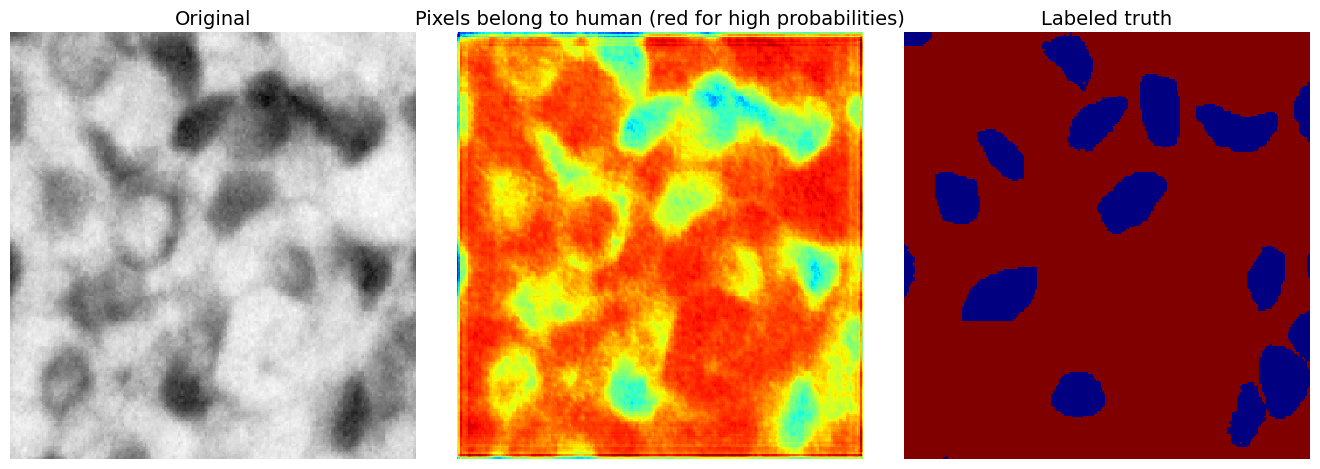

In [53]:
i_sample = 12

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);


In [54]:
from keras_unet_collection import losses

def hybrid_loss(y_true, y_pred):

    loss_focal = losses.focal_tversky(y_true, y_pred, alpha=0.5, gamma=4/3)
    loss_iou = losses.iou_seg(y_true, y_pred)
    
    # (x) 
    #loss_ssim = losses.ms_ssim(y_true, y_pred, max_val=1.0, filter_size=4)
    
    return loss_focal+loss_iou #+loss_ssim

In [55]:
import tensorflow as tf

print('Testing set cross-entropy loss = {}'.format(np.mean(keras.losses.categorical_crossentropy(test_label, y_pred))))
print('Testing set focal Tversky loss = {}'.format(np.mean(losses.focal_tversky(test_label, y_pred))))
print('Testing set IoU loss = {}'.format(np.mean(losses.iou_seg(test_label, y_pred))))

print('Testing Dice = {}'.format(np.mean(losses.dice(test_label, y_pred))))

 


m = keras.metrics.Recall()
m.update_state(test_label, y_pred)
print(m.result())

m1 = keras.metrics.AUC(num_thresholds=3)
m1.update_state(test_label, y_pred)
print(m1.result())


m3 = keras.metrics.RecallAtPrecision(0.8)
m3.update_state(test_label, y_pred)
m3.result()

Testing set cross-entropy loss = 0.36237388849258423
Testing set focal Tversky loss = 0.25327467918395996
Testing set IoU loss = 0.27622848749160767
Testing Dice = 0.16024667024612427
tf.Tensor(0.88056487, shape=(), dtype=float32)
tf.Tensor(0.88056487, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.9809116>

In [56]:
from keras.optimizers import Adam

# Metrics
from tensorflow.keras.metrics import *

prec_score = Precision()
prec_score.update_state(y_pred, test_label)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)



Precision Score = 1.000


In [57]:
y_pred_thresholded = y_pred > 0.5

# mean Intersection-Over-Union metric
#IOU_keras = MeanIoU(num_classes=2)
#IOU_keras.update_state(y_pred_thresholded, test_label_names)
#print("Mean IoU =", IOU_keras.result().numpy())

prec_score = Precision()
prec_score.update_state(y_pred_thresholded, y_pred)
p = prec_score.result().numpy()
print('Precision Score = %.3f' % p)

recall_score = Recall()
recall_score.update_state(y_pred_thresholded, y_pred)
r = recall_score.result().numpy()
print('Recall Score = %.3f' % r)

f1_score = 2*(p*r)/(p+r)
print('F1 Score = %.3f' % f1_score)

Precision Score = 1.000
Recall Score = 1.000
F1 Score = 1.000


## Discussion

A segmentation model is proposed based on the architecture of UNET 3+ and is trained using the Oxford-IIIT Pets dataset. Result evaluation indicates that this segmentation model can distinguish pixes of a pet from image backgrounds.

Many technical details of this work, for example, network hyper-parameters and training strategy, can be improved for achieving better performance. 